## Endogenous Grid Method
The Endogenous Grid Method Module in Alisdair McKay's series on Heterogenous Agent Modeling.

In [1]:
# load packages
import matplotlib.pyplot as plt
from scipy import sparse
import numpy as np
import warnings

# config
A_MIN = 0
A_MAX = 100
N_A = 251
ENDOWMENT = 2 * np.array([1, 5])  # low and high endowments
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
BETA = 0.99
GAMMA = 2.
R = 1 / BETA

#### The Model
Consider an economy where the representative consumer has CRRA preferences
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma},
$$
and a fluctuating income $e$ with transition probabilities $\Pi(e' \mid e)$ that can take on two values, $e_{l}$ and $e_h$ where $e_l < e_h$. The consumer also can hold a risk-free bond $a$ with gross return $R$. Therefore, they have the budget constraint
$$
a' + c \leq Ra + e.
$$

The consumer also faces the borrowing constraint $a \geq \underline{a}$. We can represent the solution to the consumer's problem as the savings function $g$ and consumption function $c$ such that
\begin{align*}
g(a, e) &= a' \\
c(a, e) &= c = Ra + e - g(a, e).
\end{align*}

Therefore, the consumer problem can be written as the bellman equation
\begin{align*}
V(a, e) = \max_{c, a'} \quad & \frac{c^{1-\gamma}}{1-\gamma} + \beta V(a', e') \\
\quad \text{subject to} \quad & a' + c \leq Ra + e \\
& a' \geq \underline{a}
\end{align*}
which becomes the Lagrangian
$$
\mathcal{L} = \frac{c^{1-\gamma}}{1-\gamma} + \lambda (Ra + e - a' - c) + \mu (a' - \underline{a}) + \beta V(a', e')
$$
which has the FOCs
\begin{align*}
c^{-\gamma} &= \lambda \\
\beta V_{a'}(a', e') &= \lambda - \mu
\end{align*}
and envelope condition
$$
V_{a'}(a', e') = R \lambda'.
$$
Plugging these in gets the equation
$$
c^{-\gamma} = \beta R c^{\prime -\gamma} + \mu
$$
or
$$
c^{-\gamma} \geq \beta R c^{\prime -\gamma}
$$
which holds with equality whenever the budget constraint isn't binding.

To solve this model using the endogenous grid method, we assume policy function $g_n$ and next period asset holdings $A = a'$. Then, using the Euler equation, we get
$$
c_n(a, e)= \left(\beta R \mathbb{E} \left[\left(R A + e' - g_n(A, e')\right)^{-\gamma}\right]\right)^{\frac{-1}{\gamma}}
$$
Using the budget constraint, we get
$$
a = \frac{1}{R} \left(c_n(a, e) + A - e\right)
$$
which gives us a new policy function $g_{n+1}$ that goes from $(a, e)$ to $A$.

We then replicate this process along a grid of $A$ values in order to solve for the policy function along an entire domain.

#### Setup
To start the process, we use a grid. 

In [2]:
# gridpoints
grid = np.linspace(A_MIN**(1/4), A_MAX**(1/4), N_A)**4
# we use a grid with more points near the borrowing constraint since there is more curvature there, see Reiter 2009
tiled_grid = np.tile(grid, ENDOWMENT[:, None].shape).T  # each row is a different income level. Represent g as a function of only this vector

#### Setup Interpolation
To update the policy function across all numbers, we interpolate our policy rule with a Linear Spline interpolation.

I also tried it with a cubic spline and rational interpolation, but it becomes unstable with a dense grid, so this is better.

In [3]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)

    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m*(X - x_l)  
    
    return linear_interpolation


def get_g(a, A=grid, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a.shape[1]
    splines = [spline(a[:, i], A) for i in range(num_endows)]

    def g(a):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_prime = np.column_stack([splines[i](a[:, i]) for i in range(num_endows)])
        a_prime[a_prime < A_MIN] = A_MIN
        return a_prime
    
    return g


def get_c(g):
    '''
    Takes a saving function and returns the consumption function
    '''
    c = lambda a: R*a + ENDOWMENT - g(a)  # consumption = assets + endowment - next assets
    return c

#### Endogenous Grid Method
Use the endogenous grid method to update our functions $g$ and $c$ until they converge within some tolerance.

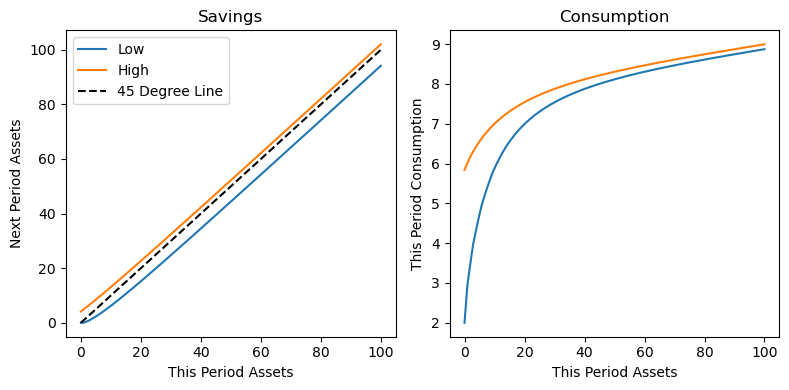

In [5]:
# initial guess
a_current = 10 + 0.1*tiled_grid  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_current)
c = get_c(g)

# loop
tol = 1e-10
max_iter = 10000
for _ in range(max_iter):
    # update rule
    c_prime = c(tiled_grid)
    deriv_u_prime = c_prime**(-GAMMA)
    expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
    c_current = (BETA * R * expect_deriv_u_prime)**(-1/GAMMA)
    a_current = 1/R * (c_current + tiled_grid - ENDOWMENT)

    # make functions
    g, last_g = get_g(a_current), g
    c = get_c(g)

    # exit conditions
    diff = np.abs(g(tiled_grid) - last_g(tiled_grid)).max()
    if diff < tol:
        break
else:
    warnings.warn('Max iteration count exceeded')

# setup plot
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)
ax[0].set_title('Savings')
ax[0].set_xlabel('This Period Assets')
ax[0].set_ylabel('Next Period Assets')
ax[1].set_title('Consumption')
ax[1].set_xlabel('This Period Assets')
ax[1].set_ylabel('This Period Consumption')

# plot it
ax[0].plot(grid, g(tiled_grid), label=['Low', 'High'])
ax[0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
ax[1].plot(grid, c(tiled_grid))

# final things
ax[0].legend()
fig.tight_layout()